# An example demonstrating the use of Hydro Code (Timeseries Example)

**Importing the modules**

In [1]:
from usgs_api import get_data
from hydrogenerate import calculate_potential,get_energy
from hydrogenerate_plot import get_plot

USGS site: https://maps.waterdata.usgs.gov/mapper/index.html

This website lists various streamflow data either in 15min or 24hr window for several locations in the United States

# Getting data from [USGS (NWIS)]( https://maps.waterdata.usgs.gov/mapper/index.html)

**get\_data(site\_no,begin\_date,end\_date)**

User input if they want a daily (24hr) or 15 min interval data. 

_Note: Some streams do not report 15min data. If the dataframe is returned empty check the USGS website._

**Input**:

**site\_no:** Provide the HUC ID for the stream, this is an unique identifier for every stream, **Type: String**

**begin\_date** and **end\_date** Range of days for which data is to be collected from the [NWIS](https://maps.waterdata.usgs.gov/mapper/index.html) server, _format: YYYY-MM-DD_, **Type: String**


If 15min data is selected user gets an option to aggregate the data in an hourly format for further calculation.

**Returns: Dataframe**

**Note: This function handles any missing data from NWIS**

In [2]:
site_no='11421000'
begin_date = '2019-01-01'
end_date = '2020-03-20'

In [3]:
flow_info = get_data(site_no,begin_date,end_date)

Data Options (15min/Daily): 15min
Do you need hourly data (Y/N): Y
There is data missing in the NWIS database
Missing data filled


C:\Users\mitr284\Work\GitHub\My_Code\My_Code\My_HAT\usgs_api.py:162: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  flow_info = flow_info.resample('60min').mean()


# Flow information obtained from USGS

In [4]:
flow_info.head()

,Date/Time,Site_ID,Flow (cfs)
0,2019-01-01 00:00:00,11421000.0,797.00
1,2019-01-01 01:00:00,11421000.0,799.00
2,2019-01-01 02:00:00,11421000.0,806.50
3,2019-01-01 03:00:00,11421000.0,812.00
4,2019-01-01 04:00:00,11421000.0,835.25


## Note: If you have your own data read it as a dataframe and follow the rest of the procedure:

**import pandas as pd**

**flow_info = pd.read_csv(r'path\file.csv')**

# Calculate Estimated HydroPower from Available Flow Data

**calculate\_potential(flow\_info, rated\_flow= None, rated\_power= None, turb= None,
head\_input= 100, op= 'Timeseries', sys\_effi= None, system= 'pipe', flow\_column= None)** 


**Input:**

**flow\_info:** Dataframe consisting of flow information.

**rated\_flow:** Design flow of the plant or channel in cubic feet/sec (cfs). If **None** or not provided, the maximum flow from the available data is considered as design flow. For **op:** _'Generalized'_, user must provide **rated\_flow**.  **Type: Float**

**rated\_power:** Rated or maximum capacity of turbine installed in MegaWatts (MW). If **None** or not provided, 75<sup>th</sup> percentile of computed power is considered as rated power, **Type: Float**.

**turb**: Provide a choice for turbine selection. If **None** or not provided an appropriate turbine selection is made based on provided head.  **Type: String**

_Options_: 
           
- **Kaplan Turbine**;

- **Francis Turbine**;

- **Pelton Turbine**;

- **Turgo Turbine**;

- **Crossflow Turbine**;

- **Turgo Turbine**.


Default turbine selection based on **head_input:**

|Head Category|Start (m)|End (m)|Suitable Turbine|k<sub>2</sub>|
|--------------|-------|-------|-------|-------|
|Very low head|0.5|10|Kaplan turbine|800|
|Low head|10|60|Kaplan turbine|800|
|Medium head|60|150|Francis turbine|600|
|High head|150|350|Francis turbine|600|
|Very high head|350|700|Pelton turbine|0|


**head\_input:** Head information provided by the user in feet (ft.).  **Type: Float**

**op:** Options: {_'Generalized'_ and _'Timeseries'_}; **Default: 'Timeseries'**. **Type: String**

- **'Generalized'** provides power in MW as a percentage of streamflow, 

- **'Timeseries'** calculates power in MW from timeseries streamflow values,

**sys\_effi:** Water to wire efficiency, If **None** or not provided **Default: 0.98 (98%)**, **Type: Float**

**system:** Options:{_'pipe'_, _'canal'_ and _'reservoir'_}, **Default: 'pipe'**, **Type: String**

System determines the percentage loss or head loss;

For _'pipe': 5\%_; _'canal': 20\%_ and _'reservoir': 0.1\%_

**flow\_column:** Name of the column containing flow information; If **None** or not provided **Default: 'Flow (cfs)'**, **Type: String**

**Returns:** 

Dictionary: **{'power', 'efficiency', 'flow', 'turb\_cap'}**

**power:** Numpy array of estimated power in MW

**efficiency:** Numpy arrary of estimated turbine efficiency in percentage

**flow:** Numpy array of water flow rate in cu.m/s

**turb_cap:** Float value of estimated turbine capacity in MW

# Time series Example

In [5]:
x= calculate_potential(flow_info,head_input=40,op='Timeseries',system='reservoir')

**Assigning Variable Names to the elements in the dictionary**

In [6]:
power = x["power"]

efficiency = x["efficiency"]

flow_range = x["flow"]

turb_cap = x["turbine_capacity"]

# Calculate Energy Potential and Estimated Costs


**get\_energy(power, turb\_cap, flow\_info, time\_step= None, op, energy\_cost= None, const\_cost= None)**

**Input:**

**power:** Numpy array containing calculated power.

**flow\_info:** DataFrame consisting of flow information.

**turb\_cap:** Turbine capacity obtained from the previous function.

**op:** Same as previous function.

**time\_step:** Essential for computing total energy in MWh; If **None** or not provided takes the _'Date/Time'_ column from **flow\_info**. If provided by user input needs to be in hrs. **Type: Float**

**energy\_cost:** Sale price of energy generated in Dollars. If **None** or not provided defaults to **4 cents/kWh**.

**const\_cost:** Estimated cost of construction of the plant. If **None** or not provided defaults to **4.1 million \$/MW**.

**Returns:**

_Total Estimated Energy in MWh_

_Expected Annual Revenue in \$_

_Expected Construction Cost in \$_

In [7]:
tot_mwh,revenue,const_cost = get_energy(power,turb_cap,op='Timeseries',flow_info=flow_info)

In [8]:
print('Total Energy: {} MWh'.format(tot_mwh))
print('Total Expected Revenue: $ {}'.format(revenue))
print('Total Cost of Construction: {} Million $'.format(const_cost))

Total Energy: 10742.503503562839 MWh
Total Expected Revenue: $ 4297.0014014251365
Total Cost of Construction: 14.64162430831379 Million $


# Plotting the results

**get\_plot(power, efficiency, flow\_range, op, flow\_info= None, rated_flow = None, font= None, fontsize= None)**
             
**Input**:

**font:** Determines the type of font, Default: _'Times New Roman'_.

**fontsize:** Determines the type of fontsize, Default: 15.

**Returns:**

A Plot

Provide a title for the figure: Timeseries


findfont: Font family 'Time New Roman' not found.
findfont: Font family 'Time New Roman' not found.
findfont: Font family 'Time New Roman' not found.
findfont: Font family 'Time New Roman' not found.
findfont: Font family 'Time New Roman' not found.
findfont: Font family 'Time New Roman' not found.
findfont: Font family 'Time New Roman' not found.
findfont: Font family 'Time New Roman' not found.
findfont: Font family 'Time New Roman' not found.
findfont: Font family 'Time New Roman' not found.
findfont: Font family 'Time New Roman' not found.


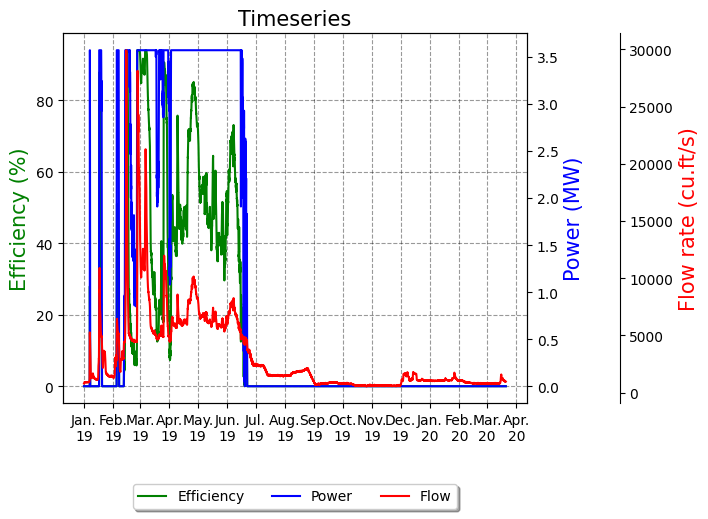

In [9]:
get_plot(power,efficiency,flow_range,op='Timeseries',flow_info=flow_info)